# Implementation of Digital Recogniser with PyTorch

### Import the libraries

In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import matplotlib.pyplot as plt

### Load the dataset

In [2]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform=ToTensor(),
    download=True
    
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform=ToTensor(),
    download=True
    
)

### Check for total datapoints in the dataset

In [3]:
print('Total training data:\n---------------------\n {}\n\nTotal testing data:\n---------------------\n {}'.format(train_data, test_data))

Total training data:
---------------------
 Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Total testing data:
---------------------
 Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


### Check for the classes for both training and testing data

In [4]:
train_data.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [5]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [6]:
for j in train_data.classes:
    print(j)

0 - zero
1 - one
2 - two
3 - three
4 - four
5 - five
6 - six
7 - seven
8 - eight
9 - nine


### Check for tensor image data and its shape

In [7]:
test_data.data.shape
print('The total image for the testing data: {}\nHeight of the image: {}\nWidth of the image: {}'.format(test_data.data.shape[0], test_data.data.shape[1],test_data.data.size()[2]))

The total image for the testing data: 10000
Height of the image: 28
Width of the image: 28


In [8]:
test_data.data.shape
print('The total image for the testing data: {}\nHeight of the image: {}\nWidth of the image: {}'.format(train_data.data.shape[0], train_data.data.shape[1],train_data.data.size()[2])), train_data.data[:2]

The total image for the testing data: 60000
Height of the image: 28
Width of the image: 28


(None,
 tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8))

### Load the data in batches

In [9]:
loaders = {
    'train': DataLoader(train_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1),
    
    'test': DataLoader(test_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1)
}

In [10]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x25c9026bed0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x25c90248590>}

### Create the class model

In [11]:
class DigitalCNN(nn.Module):
    def __init__(self):
        super(DigitalCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        #self.conv3 = nn.Conv2d(20, 20, kernel_size=5, stride=1, padding=1)
        self.conv2_drop = nn.Dropout2d()
        
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
         x = F.relu(F.max_pool2d(self.conv1(x), 2))
         #x = F.relu(F.max_pool2d(self.conv2(x), 2))
         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
         x = x.view(x.size(0), 320)
         x = F.relu(self.fc1(x))
         x = F.dropout(x, training=self.training)
         x = self.fc2(x)
        
         return F.softmax(x)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Create a training model

In [13]:
model = DigitalCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

### Create a training loop function

In [14]:
def train(epoch):
    model.train()
    for batch, (feature, target) in enumerate(loaders['train']):
        feature, target = feature.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(feature)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch * len(feature)}/{len(loaders["train"].dataset)} ({100. * batch / len(loaders["train"]):.0f}%)]\t{loss.item():.6f}')

### Create a test loop function

In [15]:
def test():
    model.eval()
    test_loss, correct =0, 0
    with torch.inference_mode():
        for feature, target in loaders['test']:
            feature, target = feature.to(device), target.to(device)
            output = model(feature)
            test_loss += loss_fn(output, target).item()
            test_pred = output.argmax(dim=1)
            correct += test_pred.eq(target.view_as(test_pred)).sum().item()
            
    test_loss /= len(loaders['test'].dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy {correct}/{len(loaders['test'].dataset)} ({100. * correct / len(loaders['test'].dataset):.0f}%\n)")

In [16]:
EPOCHS = 3
for epoch in range(EPOCHS):
    train(epoch)
    test()

C:\Users\Saheed\AppData\Local\Temp\ipykernel_13544\1112552566.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train Epoch: 0 [0/60000 (0%)]	2.300822
Train Epoch: 0 [1000/60000 (2%)]	2.301875
Train Epoch: 0 [2000/60000 (3%)]	2.302155
Train Epoch: 0 [3000/60000 (5%)]	2.303017
Train Epoch: 0 [4000/60000 (7%)]	2.300656
Train Epoch: 0 [5000/60000 (8%)]	2.300369
Train Epoch: 0 [6000/60000 (10%)]	2.300863
Train Epoch: 0 [7000/60000 (12%)]	2.299006
Train Epoch: 0 [8000/60000 (13%)]	2.299054
Train Epoch: 0 [9000/60000 (15%)]	2.295732
Train Epoch: 0 [10000/60000 (17%)]	2.298838
Train Epoch: 0 [11000/60000 (18%)]	2.293825
Train Epoch: 0 [12000/60000 (20%)]	2.294786
Train Epoch: 0 [13000/60000 (22%)]	2.289449
Train Epoch: 0 [14000/60000 (23%)]	2.281043
Train Epoch: 0 [15000/60000 (25%)]	2.273129
Train Epoch: 0 [16000/60000 (27%)]	2.283335
Train Epoch: 0 [17000/60000 (28%)]	2.247377
Train Epoch: 0 [18000/60000 (30%)]	2.255954
Train Epoch: 0 [19000/60000 (32%)]	2.212951
Train Epoch: 0 [20000/60000 (33%)]	2.240427
Train Epoch: 0 [21000/60000 (35%)]	2.219192
Train Epoch: 0 [22000/60000 (37%)]	2.195683
Train E

In [17]:
lst_digits = []
for i in train_data.classes:
    lst_digits.append(i)
print(lst_digits)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


### Predict and evaluate the model

Please Enter the index number to predict its digit: 4


C:\Users\Saheed\AppData\Local\Temp\ipykernel_13544\1112552566.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Prediction: 4


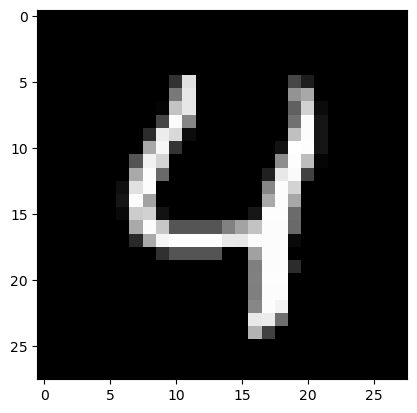

In [21]:
model.eval()
index_num = int(input('Please Enter the index number to predict its digit: '))
feature, target = test_data[index_num]
feature = feature.unsqueeze(0).to(device)
output = model(feature)
prediction = output.argmax(dim=1).item()
print('Prediction: {}'.format(prediction))
image = feature.squeeze(0).squeeze(0).cpu().numpy()
plt.imshow(image, cmap='gray')
plt.show()